# CatBoost models

## Data
We analyze three data sets, which are two incremental subsets and the full data set. We first analyze data from pregnancy and early-life (0-1 years, phase 1-2). Next we analyze all data up to age 11-12 (phase 4). Finally, we include environmental data, such as data from the built environment, traffic, and air pollution (Geodata and Exposome).

The data are preprocessed in R. After preprocessing, we obtain three data sets with $N=2224$ and $p=185$ (0-1 years), $p=380$ (11-12 years), and $p=530$ (11-12 years + environmental data).

In [1]:
import numpy as np
import pandas as pd
from catboost import Pool, CatBoostClassifier, cv, EFstrType
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
%matplotlib inline
from numba import NumbaDeprecationWarning
import warnings
warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
import shap

In [2]:
X = pd.read_csv("dataset-phase4-nonimputed.csv")

y = X['TotaalSDQkind_f5'].values
y[np.where(y < np.percentile(y, 90))[0]] = 0
y[np.where(y >= np.percentile(y, 90))[0]] = 1

X = X.drop(['ID','TotaalSDQkind_f5'], axis=1)

# subtract 2 because the first column is removed and 
categorical_features_indices = np.loadtxt("cat_features-dataset-phase4-nonimputed.txt", dtype=int) - 2

categorical_features_indices=categorical_features_indices[1:]

# convert categorical feature values to strings
q = ['str']*len(categorical_features_indices)
foo = dict(zip(X.columns[categorical_features_indices], q))
X = X.astype(foo)

## Data splitting

In [3]:
X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.8, random_state=123)

train_data = Pool(data = X_train,
                  label = y_train,
                  cat_features = categorical_features_indices)

validation_data = Pool(data = X_validation,
                  label = y_validation,
                  cat_features = categorical_features_indices)

## Train baseline

Before tuning any other parameters, we first tune learning rate and number of iterations manually with a trial run.

In [4]:
model = CatBoostClassifier(loss_function='Logloss',
                           class_weights=[0.1,0.9],
                           random_state=0)

model.fit(X_train, y_train, 
          cat_features = categorical_features_indices,
          eval_set=(X_validation, y_validation),
          verbose=500,
          plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.036534
0:	learn: 0.6859881	test: 0.6881444	best: 0.6881444 (0)	total: 91.9ms	remaining: 1m 31s
500:	learn: 0.0535676	test: 1.0755954	best: 0.6118347 (49)	total: 18s	remaining: 17.9s
999:	learn: 0.0149029	test: 1.4867265	best: 0.6118347 (49)	total: 35.9s	remaining: 0us

bestTest = 0.6118346831
bestIteration = 49

Shrink model to first 50 iterations.


In the logging output we can read the iteration with the best value, the chosen learning rate, and the performance (measured in log-loss) on the evaluation set. 

## Grid search

To perform a grid search we use Scikit-learn GridsearchCV functionality. We first define the model with a sufficiently large number of iterations. In the fit() function we set the early_stopping_rounds parameter which ensures each model stops training after the loss function has not improved for a defined number of iterations. This saves a lot of time.
Because gridSearchCV by default maximizes the scoring function we use the negative log-loss (as the log-loss must be minimized). 

In [5]:
model = CatBoostClassifier(iterations=1e3,
                           class_weights=[0.1,0.9],
                           random_state=0)

# Define parameter grid
param_grid = {
    'depth': [2, 4, 6]
}

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=model,
                           param_grid=param_grid,
                           scoring='neg_log_loss',#'roc_auc',
                           cv=5,
                           verbose=4)

grid_search.fit(X_train, y_train, 
                cat_features=categorical_features_indices,
                eval_set=(X_validation, y_validation),
                early_stopping_rounds=50,
                verbose=0) 

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END ..........................depth=2;, score=-0.588 total time=   0.9s
[CV 2/5] END ..........................depth=2;, score=-0.632 total time=   0.6s
[CV 3/5] END ..........................depth=2;, score=-0.600 total time=   0.6s
[CV 4/5] END ..........................depth=2;, score=-0.600 total time=   0.8s
[CV 5/5] END ..........................depth=2;, score=-0.604 total time=   0.9s
[CV 1/5] END ..........................depth=4;, score=-0.568 total time=   1.4s
[CV 2/5] END ..........................depth=4;, score=-0.586 total time=   1.1s
[CV 3/5] END ..........................depth=4;, score=-0.535 total time=   1.4s
[CV 4/5] END ..........................depth=4;, score=-0.602 total time=   0.9s
[CV 5/5] END ..........................depth=4;, score=-0.571 total time=   1.2s
[CV 1/5] END ..........................depth=6;, score=-0.527 total time=   3.5s
[CV 2/5] END ..........................depth=6;, 

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x121b80c40>,
             param_grid={'depth': [2, 4, 6]}, scoring='neg_log_loss',
             verbose=4)

The best parameter combination can be found with the best_params_ method.

In [6]:
grid_search.best_params_

{'depth': 6}

We can also print an overview of the results.

In [7]:
gs_results = pd.DataFrame({'depth': grid_search.cv_results_['param_depth'],
                    'acc': grid_search.cv_results_["mean_test_score"]})

print(gs_results.sort_values(by=['acc'],ascending=False))

  depth       acc
2     6 -0.547366
1     4 -0.572513
0     2 -0.604724


## Train final model

We train the final model with the optimized tree depth.

In [8]:
model = CatBoostClassifier(loss_function='Logloss',
                           early_stopping_rounds=50,
                           depth=grid_search.best_params_['depth'],
                           class_weights=[0.1,0.9],
                           random_state=0)

model.fit(X_train, y_train, 
          cat_features = categorical_features_indices,
          eval_set=(X_validation, y_validation),
          verbose=500,
          plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.036534
0:	learn: 0.6859881	test: 0.6881444	best: 0.6881444 (0)	total: 36.7ms	remaining: 36.6s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6118346831
bestIteration = 49

Shrink model to first 50 iterations.


## Store/load models

In [ ]:
'''model.save_model("/Users/philip/Documents/postdoc/vumc/abcd/models/classifier-sdq-fase4-default-02",
                format="cbm")'''

In [ ]:
'''model = CatBoostClassifier()
model.load_model("/Users/philip/Documents/postdoc/vumc/abcd/models/classifier-sdq-fase4-default-02")'''

## Evaluate performance

We calculate several classification performances, both manually and using scikit-learn functionality where possibile.

In [9]:
preds = model.predict(X_validation)

probs = model.predict_proba(X_validation)

# Error rate / accuracy
errors=0
for i in range(len(y_validation)):
    if preds[i] != y_validation[i]:
        errors+=1
acc = 1 - errors/len(X_validation)

tp=0
fp=0
tn=0
fn=0
for i in range(len(preds)):
    if preds[i] == 1:
        if y_validation[i] == 1:
            tp += 1
        else:
            fp += 1
    if preds[i] == 0:
        if y_validation[i] == 0:
            tn += 1
        else:
            fn += 1

performances = pd.DataFrame({'AUC': ['-', roc_auc_score(y_validation, probs[:,1])],
                             'Accuracy': [acc, accuracy_score(y_validation,preds)],
                             'Sensitivity:': [tp/(tp+fn), recall_score(y_validation,preds)],
                             'Specificity:': [tn/(fp+tn), '-'],
                             'Precision:': [tp/(tp+fp), precision_score(y_validation,preds)],
                             'F-measure:': [2*tp/(2*tp+fp+fn), f1_score(y_validation,preds)]}, index=['Manually', 'scikit-learn'])

performances.head()

,AUC,Accuracy,Sensitivity:,Specificity:,Precision:,F-measure:
Manually,-,0.764045,0.54,0.792405,0.247706,0.339623
scikit-learn,0.758582,0.764045,0.54,-,0.247706,0.339623


## ROC curve

In [10]:
fpr, tpr, thresholds = roc_curve(y_validation, probs[:,1], pos_label=1)

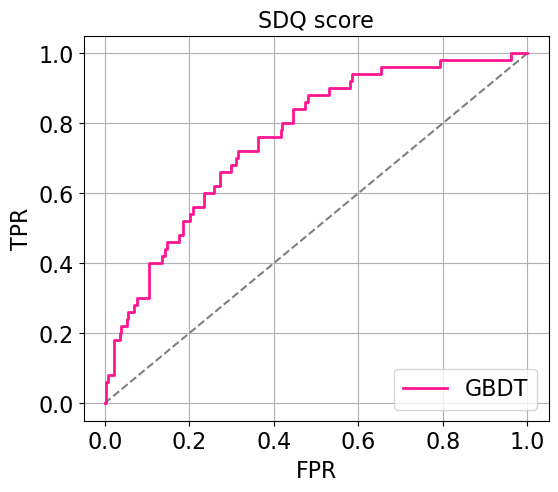

In [11]:
plt.figure(figsize=(6,5))#(8,6))
plt.plot([0,1],[0,1],"--",color="grey")
plt.plot(fpr,tpr, linewidth=2,color="deeppink",label="GBDT")
#plt.plot(1 - aucRF.specificities.values,aucRF.sensitivities.values,
#         linewidth=2,color="dodgerblue",label="Random Forest")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("FPR",fontsize = 16)
plt.ylabel("TPR",fontsize = 16)
plt.legend(fontsize=16,loc=4)
plt.title("SDQ score",fontsize=16)
plt.grid()
#plt.savefig('plots/AUC-curves-SDQ-fase4-01.jpg')
plt.show()

## SHAP analysis

We compute Shapley values using the SHAP Python package. The trained model object can be directly passed to the SHAP TreeExplainer. The TreeExplainer class can be called directly to compute SHAP values for a given dataset. The resulting SHAP values are hold by a so-called Explanation object which can be passed to plotting functions. Below we show the summary (beeswarm) plot, and a SHAP dependence scatter plot. 

In the current version of SHAP the argument 'group_remaining_features' cannot be toggled off, so that the sum of all remaining features is shown as a single feature at the bottom of the plot, which widens the horizontal scale. Therefore we use the summary plot function, which does not show this by default.

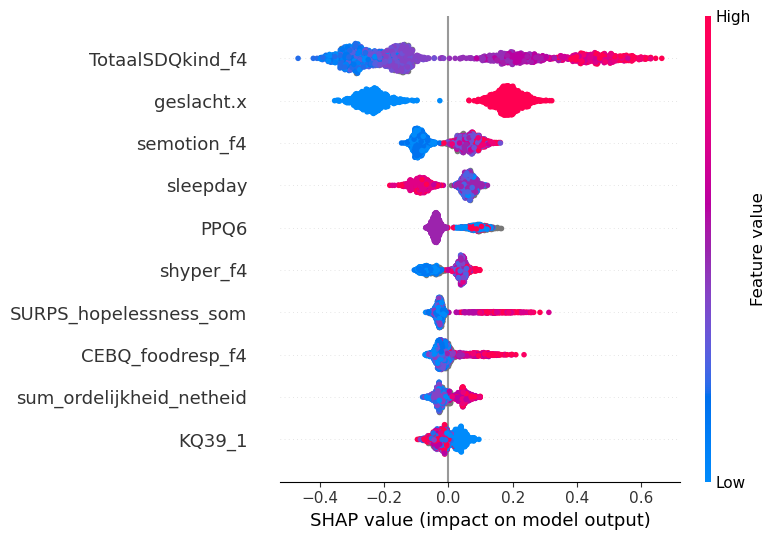

In [12]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_train)

# create a summary plot
shap.summary_plot(shap_values, max_display=10)

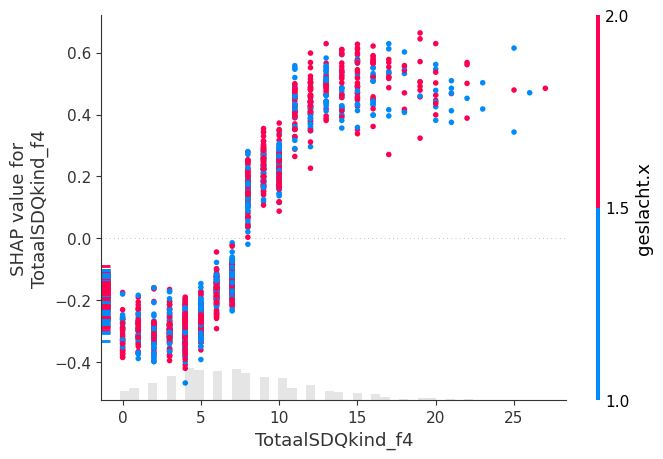

In [14]:
shap.plots.scatter(shap_values[:,"TotaalSDQkind_f4"], color=shap_values[:,"geslacht.x"])